In [1]:
import io
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Data Loading and Merging

In this notebook, we'll:
1. Load two datasets from zip archives (1_data_A.zip and 2_data_B.zip)
2. Map columns to a unified schema
3. Fix date formats and normalize data
4. Merge datasets intelligently
5. Save merged data to 3_merged_data.zip

## 1. Load Dataset A

In [2]:
# Load Dataset A from zip (in memory)
zip_path_a = 'data/1_data_A.zip'

with zipfile.ZipFile(zip_path_a, 'r') as zip_ref:
    csv_filename = zip_ref.namelist()[0]
    
    with zip_ref.open(csv_filename) as csv_file:
        df_a = pd.read_csv(csv_file)

print(f'Shape: {df_a.shape}')
df_a.head(3)

Shape: (76000, 16)


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Promotion,Competitor Pricing,Seasonality,Epidemic,Demand
0,2022-01-01,S001,P0001,Electronics,North,195,102,252,72.72,5,Snowy,0,85.73,Winter,0,115
1,2022-01-01,S001,P0002,Clothing,North,117,117,249,80.16,15,Snowy,1,92.02,Winter,0,229
2,2022-01-01,S001,P0003,Clothing,North,247,114,612,62.94,10,Snowy,1,60.08,Winter,0,157


#### Dataset A Overview

**Source:** `1_data_A.zip` → `sales_data.csv`

**Size:** 76,000 records × 16 columns

**Key Characteristics:**
- Store-based retail sales data
- 5 stores, 20 products, 5 categories, 4 regions
- Date range: 2022-01-01 to 2024-01-30 (2 years)
- Contains: weather, seasonality, epidemic, discount, promotion data

## 2. Load Dataset B

In [3]:
# Load Dataset B from zip (in memory)
zip_path_b = 'data/1_data_B.zip'

with zipfile.ZipFile(zip_path_b, 'r') as zip_ref:
    csv_filename = zip_ref.namelist()[0]
    print(f'Loading Dataset B: {csv_filename}')
    
    with zip_ref.open(csv_filename) as csv_file:
        df_b = pd.read_csv(csv_file)

print(f'Shape: {df_b.shape}')
df_b.head(3)

Loading Dataset B: product_sales_dataset_final.csv
Shape: (200000, 14)


,Order_ID,Order_Date,Customer_Name,City,State,Region,Country,Category,Sub_Category,Product_Name,Quantity,Unit_Price,Revenue,Profit
0,1,08-23-23,Bianca Brown,Jackson,Mississippi,South,United States,Accessories,Small Electronics,Phone Case,3,201.01,603.03,221.49
1,2,12-20-24,Jared Edwards,Grand Rapids,Michigan,Centre,United States,Accessories,Small Electronics,Charging Cable,4,74.30,297.20,97.09
2,3,01-29-24,Susan Valdez,Minneapolis,Minnesota,Centre,United States,Clothing & Apparel,Sportswear,Nike Air Force 1,1,68.19,68.19,25.47


#### Dataset B Overview

**Source:** `1_data_B.zip` → `product_sales_dataset_final.csv`

**Size:** 200,000 records × 14 columns

**Key Characteristics:**
- E-commerce order data
- 108 cities, 47 states, 49 products, 4 categories
- Date range: 2023-01-01 to 2024-12-31 (2 years)
- Contains: city/state location, product names, revenue, profit data

## 3. Map Dataset A to Target Schema

Target columns: date, city, state, location_id, product_id, product, category, region, country, sku_cost, sku_price, discount, epidemic, seasonality, weather, units_sold, revenue, profit

In [4]:
# Map Dataset A columns to target schema
df_a_mapped = pd.DataFrame()

# Direct mappings
df_a_mapped['date'] = df_a['Date']
df_a_mapped['location_id'] = df_a['Store ID']
df_a_mapped['product_id'] = df_a['Product ID']
df_a_mapped['category'] = df_a['Category']
df_a_mapped['region'] = df_a['Region']
df_a_mapped['sku_price'] = df_a['Price']
df_a_mapped['discount'] = df_a['Discount']
df_a_mapped['units_sold'] = df_a['Units Sold']
df_a_mapped['weather'] = df_a['Weather Condition']
df_a_mapped['seasonality'] = df_a['Seasonality']
df_a_mapped['epidemic'] = df_a['Epidemic']

# Missing columns - set as None (not generating new data)
df_a_mapped['city'] = None
df_a_mapped['state'] = None
df_a_mapped['product'] = None
df_a_mapped['country'] = None
df_a_mapped['sku_cost'] = None
df_a_mapped['revenue'] = None
df_a_mapped['profit'] = None

# Add dataset source identifier
df_a_mapped['data_source'] = 'A'

df_a_mapped.head(3)

,date,location_id,product_id,category,region,sku_price,discount,units_sold,weather,seasonality,epidemic,city,state,product,country,sku_cost,revenue,profit,data_source
0,2022-01-01,S001,P0001,Electronics,North,72.72,5,102,Snowy,Winter,0,None,None,None,None,None,None,None,A
1,2022-01-01,S001,P0002,Clothing,North,80.16,15,117,Snowy,Winter,0,None,None,None,None,None,None,None,A
2,2022-01-01,S001,P0003,Clothing,North,62.94,10,114,Snowy,Winter,0,None,None,None,None,None,None,None,A


## 4. Map Dataset B to Target Schema

In [5]:
# Map Dataset B columns to target schema
df_b_mapped = pd.DataFrame()

# Direct mappings
df_b_mapped['date'] = df_b['Order_Date']
df_b_mapped['city'] = df_b['City']
df_b_mapped['state'] = df_b['State']
df_b_mapped['location_id'] = df_b['City'].astype(str) + '_' + df_b['State'].astype(str)
df_b_mapped['product'] = df_b['Product_Name']
df_b_mapped['category'] = df_b['Category']
df_b_mapped['region'] = df_b['Region']
df_b_mapped['country'] = df_b['Country']
df_b_mapped['sku_price'] = df_b['Unit_Price'].str.strip() if df_b['Unit_Price'].dtype == 'object' else df_b['Unit_Price']
df_b_mapped['units_sold'] = df_b['Quantity']
df_b_mapped['revenue'] = df_b['Revenue'].str.strip() if df_b['Revenue'].dtype == 'object' else df_b['Revenue']
df_b_mapped['profit'] = df_b['Profit'].str.strip() if df_b['Profit'].dtype == 'object' else df_b['Profit']

# Generate product_id from Product_Name (simple hash-based ID)
# Create unique product IDs based on product name
unique_products = df_b['Product_Name'].unique()
product_id_map = {prod: f'B{str(i).zfill(4)}' for i, prod in enumerate(unique_products, start=1)}
df_b_mapped['product_id'] = df_b['Product_Name'].map(product_id_map)

# Missing columns - set as None
df_b_mapped['sku_cost'] = None
df_b_mapped['discount'] = None
df_b_mapped['epidemic'] = None
df_b_mapped['seasonality'] = None
df_b_mapped['weather'] = None

# Add dataset source identifier
df_b_mapped['data_source'] = 'B'

df_b_mapped.head(3)

,date,city,state,location_id,product,category,region,country,sku_price,units_sold,revenue,profit,product_id,sku_cost,discount,epidemic,seasonality,weather,data_source
0,08-23-23,Jackson,Mississippi,Jackson_Mississippi,Phone Case,Accessories,South,United States,201.01,3,603.03,221.49,B0001,None,None,None,None,None,B
1,12-20-24,Grand Rapids,Michigan,Grand Rapids_Michigan,Charging Cable,Accessories,Centre,United States,74.30,4,297.20,97.09,B0002,None,None,None,None,None,B
2,01-29-24,Minneapolis,Minnesota,Minneapolis_Minnesota,Nike Air Force 1,Clothing & Apparel,Centre,United States,68.19,1,68.19,25.47,B0003,None,None,None,None,None,B


## 5. Fix Date Formats

Dataset A: YYYY-MM-DD format  
Dataset B: MM-DD-YY format (needs conversion)

In [6]:
# Fix dates in Dataset A
df_a_mapped['date'] = pd.to_datetime(df_a_mapped['date'], format='%Y-%m-%d', errors='coerce')
print(f'Dataset A date range: {df_a_mapped["date"].min()} to {df_a_mapped["date"].max()}')

# Fix dates in Dataset B (MM-DD-YY format)
df_b_mapped['date'] = pd.to_datetime(df_b_mapped['date'], format='%m-%d-%y', errors='coerce')
print(f'Dataset B date range: {df_b_mapped["date"].min()} to {df_b_mapped["date"].max()}')

# Check for invalid dates
invalid_a = df_a_mapped['date'].isna().sum()
invalid_b = df_b_mapped['date'].isna().sum()
print(f'\nInvalid dates in Dataset A: {invalid_a}')
print(f'Invalid dates in Dataset B: {invalid_b}')

Dataset A date range: 2022-01-01 00:00:00 to 2024-01-30 00:00:00
Dataset B date range: 2023-01-01 00:00:00 to 2024-12-31 00:00:00

Invalid dates in Dataset A: 0
Invalid dates in Dataset B: 0


## 6. Consistent Date Period

To create a more balanced dataset we:
1. Detect the date overlap between both datasets
2. Filter both datasets to only include the overlap period

In [7]:
# Get date ranges for each dataset
date_a_min = df_a_mapped['date'].min()
date_a_max = df_a_mapped['date'].max()
date_b_min = df_b_mapped['date'].min()
date_b_max = df_b_mapped['date'].max()

print(f'\nDataset A: {date_a_min.date()} to {date_a_max.date()}')
print(f'  Duration: {(date_a_max - date_a_min).days} days')
print(f'  Records: {len(df_a_mapped):,}')

print(f'\nDataset B: {date_b_min.date()} to {date_b_max.date()}')
print(f'  Duration: {(date_b_max - date_b_min).days} days')
print(f'  Records: {len(df_b_mapped):,}')

# Calculate overlap period
overlap_start = max(date_a_min, date_b_min)
overlap_end = min(date_a_max, date_b_max)

print(f'\nOVERLAP PERIOD: {overlap_start.date()} to {overlap_end.date()}')
print(f'Duration: {(overlap_end - overlap_start).days} days')


Dataset A: 2022-01-01 to 2024-01-30
  Duration: 759 days
  Records: 76,000

Dataset B: 2023-01-01 to 2024-12-31
  Duration: 730 days
  Records: 200,000

OVERLAP PERIOD: 2023-01-01 to 2024-01-30
Duration: 394 days


In [8]:
# Before filtering
before_a = len(df_a_mapped)
before_b = len(df_b_mapped)

# Apply date filter
df_a_mapped_filtered = df_a_mapped[(df_a_mapped['date'] >= overlap_start) & (df_a_mapped['date'] <= overlap_end)].copy()
df_b_mapped_filtered = df_b_mapped[(df_b_mapped['date'] >= overlap_start) & (df_b_mapped['date'] <= overlap_end)].copy()

# After filtering
after_a = len(df_a_mapped_filtered)
after_b = len(df_b_mapped_filtered)

print(f'Total records before: {before_a + before_b:,}')
print(f'Total records after: {after_a + after_b:,} ({100 * (before_a + before_b - after_a - after_b) / (before_a + before_b):.1f}% loss)')
print(f'Dataset A = {100 * after_a / (after_a + after_b):.1f}%, Dataset B = {100 * after_b / (after_a + after_b):.1f}%')

Total records before: 276,000
Total records after: 145,164 (47.4% loss)
Dataset A = 27.2%, Dataset B = 72.8%


## 7. Consistent Categories

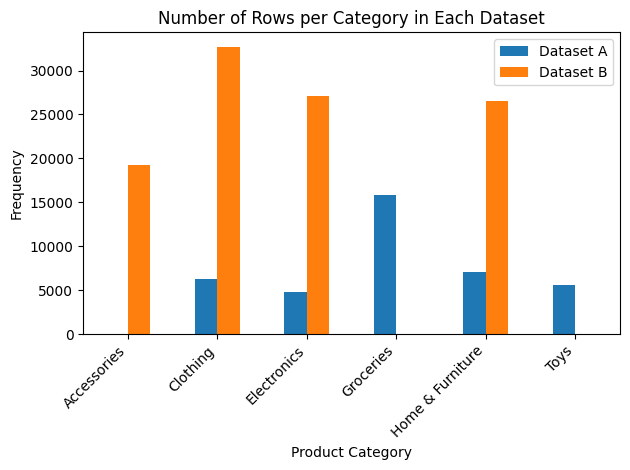

In [9]:
# Rename a category in Dataset A
df_a_mapped_filtered['category'] = df_a_mapped_filtered['category'].replace({
    'Furniture': 'Home & Furniture'
})

# Rename a category in Dataset B
df_b_mapped_filtered['category'] = df_b_mapped_filtered['category'].replace({
    'Clothing & Apparel': 'Clothing'
})

# Get category counts for both datasets
cat_a = df_a_mapped_filtered['category'].value_counts().sort_index()
cat_b = df_b_mapped_filtered['category'].value_counts().sort_index()

# Join into single DataFrame for plotting
category_df = pd.DataFrame({
    'Dataset A': cat_a,
    'Dataset B': cat_b
}).fillna(0).astype(int)

# Plot
category_df.plot(kind='bar')
plt.title('Number of Rows per Category in Each Dataset')
plt.ylabel('Frequency')
plt.xlabel('Product Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 8. Consistent regions

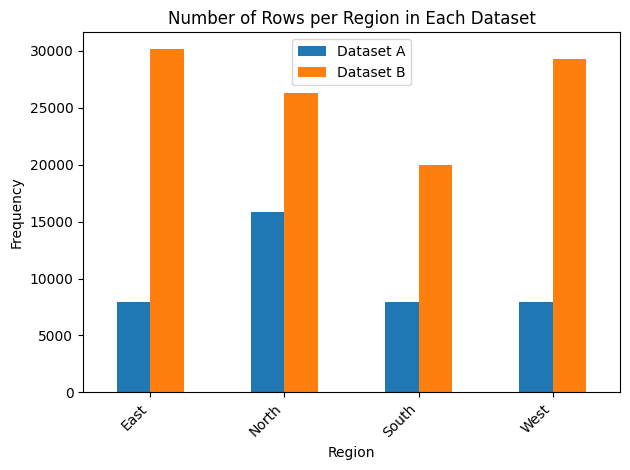

In [10]:
# Rename "Centre" region in Dataset B to "North"
df_b_mapped_filtered['region'] = df_b_mapped_filtered['region'].replace({'Centre': 'North'})

# Plot the results
region_a = df_a_mapped_filtered['region'].value_counts().sort_index()
region_b = df_b_mapped_filtered['region'].value_counts().sort_index()

# Join into single DataFrame for plotting
region_df = pd.DataFrame({
    'Dataset A': region_a,
    'Dataset B': region_b
}).fillna(0).astype(int)

# Plot
region_df.plot(kind='bar')
plt.title('Number of Rows per Region in Each Dataset')
plt.ylabel('Frequency')
plt.xlabel('Region')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 9. Merge Datasets

In [11]:
# Ensure both datasets have the same column order
target_columns = ['date', 'city', 'state', 'location_id', 'product_id', 'product', 'category', 'region', 
                  'country', 'sku_cost', 'sku_price', 'discount', 'epidemic', 
                  'seasonality', 'weather', 'units_sold', 'revenue', 'profit', 'data_source']

df_a_mapped_filtered = df_a_mapped_filtered[target_columns]
df_b_mapped_filtered = df_b_mapped_filtered[target_columns]

# Merge datasets
df_merged = pd.concat([df_a_mapped_filtered, df_b_mapped_filtered], ignore_index=True)
print(f'Dataset A records: {len(df_a_mapped_filtered):,}')
print(f'Dataset B records: {len(df_b_mapped_filtered):,}')
print(f'Total merged records: {len(df_merged):,}')

# Sort by date
df_merged = df_merged.sort_values('date').reset_index(drop=True)

print(f'\nMerged dataset date range: {df_merged["date"].min()} to {df_merged["date"].max()}')
print(f'Total days covered: {(df_merged["date"].max() - df_merged["date"].min()).days}')

Dataset A records: 39,500
Dataset B records: 105,664
Total merged records: 145,164

Merged dataset date range: 2023-01-01 00:00:00 to 2024-01-30 00:00:00
Total days covered: 394


## 10. Data Quality Checks

In [12]:
print(f'\nUnique Values:')
print(f'  Cities: {df_merged["city"].nunique()}')
print(f'  States: {df_merged["state"].nunique()}')
print(f'  Locations: {df_merged["location_id"].nunique()}')
print(f'  Products: {df_merged["product_id"].nunique()}')
print(f'  Categories: {df_merged["category"].nunique()}')
print(f'  Regions: {df_merged["region"].nunique()}')
print(f'  Countries: {df_merged["country"].nunique()}')

print(f'\nMissing Values by Column:')
missing_summary = pd.DataFrame({
    'Missing': df_merged.isnull().sum(),
    'Percent': 100 * df_merged.isnull().sum() / len(df_merged)
})
print(missing_summary[missing_summary['Missing'] > 0].sort_values('Missing', ascending=False))

print(f'\nNumerical Statistics:')
numeric_cols = ['sku_price', 'discount', 'units_sold', 'revenue', 'profit']
print(df_merged[numeric_cols].describe())


Unique Values:
  Cities: 108
  States: 47
  Locations: 113
  Products: 69
  Categories: 6
  Regions: 4
  Countries: 1

Missing Values by Column:
             Missing     Percent
sku_cost      145164  100.000000
discount      105664   72.789397
epidemic      105664   72.789397
weather       105664   72.789397
seasonality   105664   72.789397
city           39500   27.210603
state          39500   27.210603
product        39500   27.210603
country        39500   27.210603
revenue        39500   27.210603
profit         39500   27.210603

Numerical Statistics:
           sku_price     units_sold        revenue         profit
count  145164.000000  145164.000000  105664.000000  105664.000000
mean      296.407532      25.218091     709.745237     157.281717
std       275.328104      44.638351     739.170148     155.269113
min         4.830000       0.000000      17.030000       3.920000
25%        85.750000       1.000000     228.180000      58.740000
50%       191.490000       2.000000    

## 11. Preview Merged Data

In [13]:
print('Sample from Dataset A records:')
display(df_merged[df_merged['data_source'] == 'A'].head(3))

print('\nSample from Dataset B records:')
display(df_merged[df_merged['data_source'] == 'B'].head(3))

Sample from Dataset A records:


,date,city,state,location_id,product_id,product,category,region,country,sku_cost,sku_price,discount,epidemic,seasonality,weather,units_sold,revenue,profit,data_source
0,2023-01-01,None,None,S001,P0001,None,Electronics,North,None,None,73.60,5,0,Winter,Cloudy,76,NaN,NaN,A
229,2023-01-01,None,None,S003,P0020,None,Clothing,East,None,None,71.52,20,0,Winter,Sunny,178,NaN,NaN,A
230,2023-01-01,None,None,S002,P0003,None,Groceries,South,None,None,84.35,0,0,Winter,Cloudy,109,NaN,NaN,A



Sample from Dataset B records:


,date,city,state,location_id,product_id,product,category,region,country,sku_cost,sku_price,discount,epidemic,seasonality,weather,units_sold,revenue,profit,data_source
1,2023-01-01,Hartford,Connecticut,Hartford_Connecticut,B0027,Nike Running Shoes,Clothing,East,United States,None,93.63,None,None,None,None,2,187.26,46.08,B
2,2023-01-01,Omaha,Nebraska,Omaha_Nebraska,B0003,Nike Air Force 1,Clothing,North,United States,None,417.75,None,None,None,None,1,417.75,167.84,B
3,2023-01-01,Tulsa,Oklahoma,Tulsa_Oklahoma,B0006,Instant Pot,Home & Furniture,South,United States,None,43.99,None,None,None,None,2,87.98,30.36,B


## 12. Save Data

In [14]:
# Save merged data to zip file
output_zip_path = 'data/2_merged_data.zip'
output_csv_name = 'merged_sales_data.csv'

# Convert DataFrame to CSV in memory
csv_buffer = io.StringIO()
df_merged.to_csv(csv_buffer, index=False)
csv_buffer.seek(0)

# Write to zip file
with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zip_file:
    zip_file.writestr(output_csv_name, csv_buffer.getvalue())

print(f'Output file: {output_zip_path}')
print(f'CSV file inside: {output_csv_name}')
print(f'Total records: {len(df_merged):,}')

# Verify the zip file
with zipfile.ZipFile(output_zip_path, 'r') as zip_file:
    file_info = zip_file.getinfo(output_csv_name)
    print(f'\nCompressed size: {file_info.compress_size:,} bytes')
    print(f'Uncompressed size: {file_info.file_size:,} bytes')
    print(f'Compression ratio: {100 * (1 - file_info.compress_size / file_info.file_size):.1f}%')

Output file: data/2_merged_data.zip
CSV file inside: merged_sales_data.csv
Total records: 145,164

Compressed size: 2,646,860 bytes
Uncompressed size: 16,810,957 bytes
Compression ratio: 84.3%
